In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.optimize import bisect

from scipy.special import gamma, hyp1f1, j0
from scipy.integrate import quad, quad_vec
import mpmath as mp
from astropy.cosmology import Planck18 as cosmo
import astropy.units as u
import astropy.constants as const

# Takahashi Nakamura paper

/home/sparky/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
# dimensionless GW frequency
def w_f(f, M_Lsun, z_L):
    #print("freq =", f, "\nM_Lsun =", M_Lsun, "\nz_L =", z_L)
    G = 6.6743e-11 # m^3 / (kg*s^2)
    c = 299792458 # m/s
    M_sun = 1.9891e30 # kg

    
    M_L = M_Lsun * M_sun
    #print("GM/c3 = ", G * M_L / c**3, " seconds")
    return 8 * np.pi * G * M_L * (1 + z_L) * f / c**3

print("w = ", w_f(100, 100, 0.2))

w =  1.4860086518997084


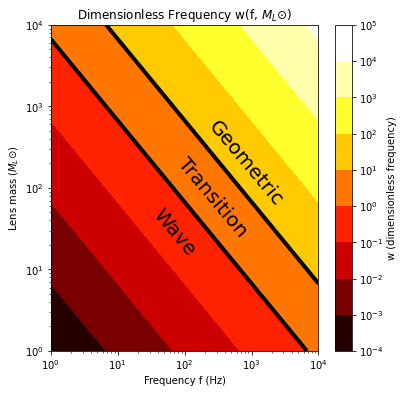

In [3]:
# Plotting dimensionless frequency (w) as function of frequency (f) and lens mass (M_L)
freq = np.linspace(1, 10000, 2000)
mass = np.linspace(1, 10000, 2000)

F, M = np.meshgrid(freq, mass)
W = w_f(F, M, 0.2)

plt.figure(figsize=(6, 6))
cp = plt.contourf(F, M, W, levels=100, cmap="hot", norm=LogNorm(vmin=W.min(), vmax=W.max()))
plt.xscale('log')
plt.yscale('log')
plt.colorbar(cp, label='w (dimensionless frequency)')

plt.contour(F, M, W, levels=[1], colors='black', linestyles='-',  linewidths=4)
plt.contour(F, M, W, levels=[10], colors='black', linestyles='-',  linewidths=4)
plt.text(30, 15, "Wave", color="black", fontsize=20, rotation=-50)
plt.text(70, 25, "Transition", color="black", fontsize=20, rotation=-50)
plt.text(200, 60, "Geometric", color="black", fontsize=20, rotation=-50)

plt.xlabel("Frequency f (Hz)")
plt.ylabel(r"Lens mass$ \;(M_L{\odot})$")
plt.title(r"Dimensionless Frequency w(f, $M_L{\odot}$)")
plt.savefig("w.png", dpi=600)
plt.show()

In [4]:
# Amplification factor equations for Point-Mass Lens
def x_m(y):
    return 0.5 * (y + np.sqrt(y**2 + 4))

def phi_m(y):
    xm = x_m(y)
    return 0.5 * (xm - y)**2 - np.log(np.abs(xm))

def hyp1f1_mp(a, b, z):
    return complex(mp.hyp1f1(a, b, z))

def F_f(w, y):
    w = np.asarray(w, dtype=np.complex128)
    
    phi = phi_m(y)
    expon_term = np.exp( 0.25*np.pi*w + (0.5*1j*w) * (np.log(0.5*w)-2*phi) )
    gamma_term = np.array([
        mp.gamma(1 - 0.5j*wi)
        for wi in w
    ], dtype=np.complex128)
    hyper_term = np.array([
        hyp1f1_mp(0.5j*wi, 1, 0.5j*wi*y*y) for wi in w
    ], dtype=np.complex128)
    return expon_term * gamma_term * hyper_term

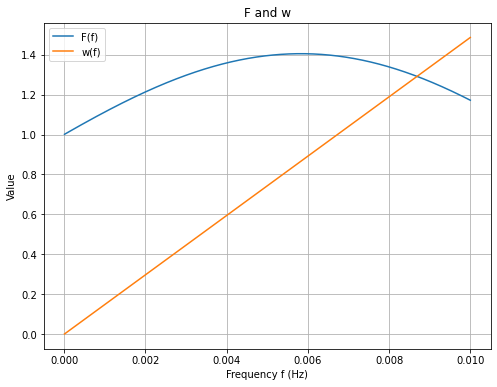

In [5]:
# F(f) vs f
M_Lsun = 1e6
y = 1

freq_vals = np.linspace(0.00001, 0.01, 2000)
w_vals = w_f(freq_vals, M_Lsun, 0.2)

amp_vals = F_f(w_vals, y)

plt.figure(figsize=(8, 6))
plt.plot(freq_vals, np.abs(amp_vals), label="F(f)")
plt.plot(freq_vals, w_f(freq_vals, M_Lsun, 0.2), label="w(f)")
plt.grid(True)
plt.xlabel("Frequency f (Hz)")
plt.ylabel("Value")
plt.title("F and w")
plt.legend()
plt.show()

In [6]:
def einstein_radius_pointmass(M_L, z_L, z_S):
    M = M_L * const.M_sun

    # Angular diameter distances
    D_L = cosmo.angular_diameter_distance(z_L)
    D_S = cosmo.angular_diameter_distance(z_S)
    D_LS = cosmo.angular_diameter_distance_z1z2(z_L, z_S)

    # Compute Einstein angular radius (radians)
    theta_E = np.sqrt((4 * const.G * M / const.c**2) * (D_LS / (D_L * D_S))).decompose()

    # Convert to arcseconds
    theta_E_arcsec = (theta_E * u.rad).to(u.arcsec)

    # Physical Einstein radius: R_E = D_L * theta_E
    R_E = (theta_E * D_L).to(u.m)

    return theta_E, theta_E_arcsec, R_E

In [7]:
# LISA-Measured Signals

G = 6.6743e-11 # m^3 / (kg*s^2)
c = 299792458 # m/s
M_sun = 1.9891e30 # kg

# just to reduce L*n to cos(i) for now for full effect...
def L_vector(i):
    return np.array([np.sin(i), 0, np.cos(i)])
def n_vector():
    return np.array([0, 0, 1])

# chirp mass
def chirp_M(M1, M2):
    return (M1*M2)**(3/5) / (M1 + M2)**(1/5)

# redshifted chirp mass
def M_z(M1, M2, z_S):
    M1 = M1 * M_sun
    M2 = M2 * M_sun
    return chirp_M(M1, M2) * (1 + z_S)
    
# amplitude
def amplitude(z_S, M_z):
    D_S = cosmo.angular_diameter_distance(z_S).to('m').value
    return np.sqrt(5/96)*np.pi**(-2/3) * (G*M_z/c**3)**(5/6) / (D_S * (1+z_S)**2)

def psi_f(f, M_z, t_c, phi_c):
    return 2*np.pi*f*t_c - phi_c - np.pi/4 + 0.75*(8*np.pi*(G*M_z/c**3)*f)**(-5/3)

# unlensed h w/ plus polarization
def h_unlensed_plus(f, Mz, z_S, i, t_c=0, phi_c=0):
    A = amplitude(z_S, Mz)
    L_n = np.dot(L_vector(i), n_vector())
    psi = psi_f(f, Mz, t_c, phi_c)
    
    h_plus = A * (1+L_n**2)* f**(-7/6) * np.exp(1j*psi)
    
    return h_plus

# unlensed h w/ cross polarization
def h_unlensed_cross(f, Mz, z_S, i, t_c=0, phi_c=0):
    A = amplitude(z_S, Mz)
    L_n = np.dot(L_vector(i), n_vector())
    psi = psi_f(f, Mz, t_c, phi_c)
    
    h_cross = -2j * A * (L_n) * f**(-7/6) * np.exp(1j*psi)
    
    return h_cross

theta_E = 0.009330989020947275 arcsec
zL=0.2, zS=1.0, y=0.0045", ML=1e7


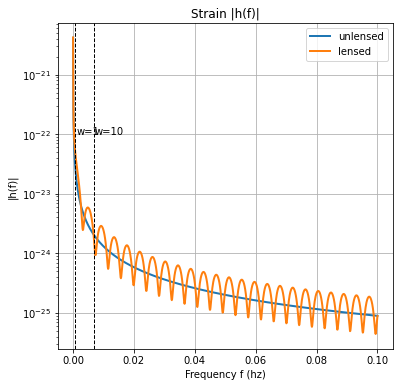

In [8]:
# LISA values
f = np.linspace(0.00001, 0.1, 1000)

M1 = 1e6
M2 = 1e6
z_S = 1

Mz = M_z(M1, M2, z_S)
h_plus = h_unlensed_plus(f, Mz, z_S, 0)

M_L = 1e7
z_L = 0.2
w = w_f(f, M_L, z_L)

print("theta_E =", einstein_radius_pointmass(M_L, z_L, z_S)[1])

def f_at_w(x, M_L, z_L):
    M_L = M_L * M_sun
    return x / (8*np.pi*(G*M_L*(1 + z_L)/c**3))
f_wave = f_at_w(1, M_L, z_L)
f_geom = f_at_w(10, M_L, z_L)

y = 0.5
Ff = F_f(w, y)

h_plus = h_unlensed_plus(f, Mz, z_S, 0)
h_plus_lensed = h_plus * Ff

plt.figure(figsize=(6, 6))
plt.plot(f, np.abs(h_plus), linewidth=2, label="unlensed")
plt.plot(f, np.abs(h_plus_lensed), linewidth=2, label="lensed")

plt.axvline(x=f_wave, color='black', linestyle='--', linewidth=1)
plt.text(f_wave + 0.0005, 1e-22, "w=1")
plt.axvline(x=f_geom, color='black', linestyle='--', linewidth=1)
plt.text(f_geom + 0.0005, 1e-22, "w=10")

plt.xlabel("Frequency f (hz)")
plt.ylabel("|h(f)|")
plt.yscale("log")
plt.legend()
plt.grid(True)
plt.title("Strain |h(f)|")
print("zL=0.2, zS=1.0, y=0.0045\", ML=1e7")
plt.show()

μ₊ =  1.5914103126634984
μ- = -0.5914103126634984
μ_geom = |μ₊| + |μ-| = 2.182820625326997


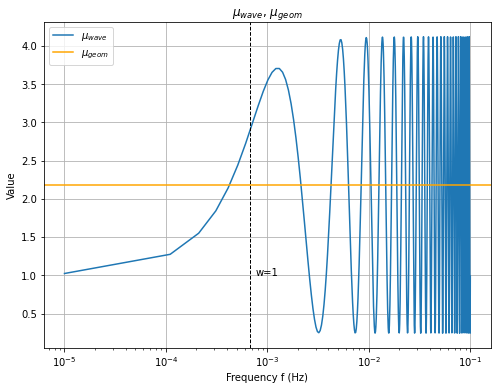

In [10]:
plt.figure(figsize=(8, 6))
plt.plot(f, np.abs(Ff)**2, label=r"$\mu_{wave}$")

mu_pos = 0.5 + (y**2 + 2)/(2*y*np.sqrt(y**2+4))
mu_neg = 0.5 - (y**2 + 2)/(2*y*np.sqrt(y**2+4))
mu_geom = np.abs(mu_pos) + np.abs(mu_neg)
print("μ₊ = ", mu_pos)
print("μ- =", mu_neg)
print("μ_geom = |μ₊| + |μ-| =", mu_geom)

plt.axvline(x=f_wave, color='black', linestyle='--', linewidth=1)
plt.text(f_wave + 0.0001, 1, "w=1")
plt.axhline(y=mu_geom, color="orange", label=r"$\mu_{geom}$")

plt.grid(True)
plt.xlabel("Frequency f (Hz)")
plt.ylabel("Value")
plt.xscale("log")
plt.title(r"$\mu_{wave}$, $\mu_{geom}$")
plt.legend()
plt.savefig("mu.png", dpi=600)
plt.show()